### Paquetes necesarios

In [97]:
##Borrar datos del entorno
rm(list=ls())


#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,janitor,webshot2,rmapshaper,
               showtext,sf, httr,jsonlite,gt,ggrepel,magick,gt, lubridate)
#Fuente para los gráficos
font_add_google("Montserrat", "pop")
showtext_auto()

### Paletas de colores

In [98]:
paleta<-c("#691c32ff", "#901d3dff","#ac2540ff","#c88f80ff","#e3c8a6ff")
paleta_mapa<- c("#7e5f33","#a27b42","#bc955c","#caac80","#d9c4a4")
#paleta<-rev(c('#bc955c','#ddc9a3','#e6cc9a','#c5c1bb','#cccccc' ))

### Funciones para ahorrar código

In [99]:
#Función para consultar la api

consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

In [100]:
actualiza_precios<-function(df,tabla_inpc){

  df<-df%>%
    #Pegar con tabla de inpc
    left_join(tabla_inpc, by = c("año" = "año"))%>%
    #Calcular precios actualizados
    #Utilizar columna Monto (millones de pesos) y multiplicar por el inpc correspondiente
    mutate(monto_actualizado=round(monto*inpc23/100,2))

  return(df)

}

In [101]:
graflinea <- function(df, valor_x, valor_y, texto_x, texto_y, titulo_grafica, subtitulo, texto_fuente, color_selec) {
  # Preparing data for the text annotation
  last_data <- df %>%
    filter(fecha == max(fecha)) %>%
    summarise(fecha = first(fecha), valor_y = first({{ valor_y }}), varpct = first(varpct))

  # Adjusting the position for the annotation by subtracting 2 days and 2 units from valor_y
  last_data$fecha <- last_data$fecha %m-% years(2)  # Subtracting 2 days
  last_data$valor_y <- last_data$valor_y - 20   # Subtracting 2 units

  # Create the plot
  p <- ggplot(df, aes(x = {{ valor_x }}, y = {{ valor_y }})) +
    geom_line(linewidth = 1.5, color = color_selec) +  # Original series
    theme_minimal() +
    labs(x = texto_x, y = texto_y, title = titulo_grafica, subtitle = subtitulo, caption = texto_fuente) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
    scale_y_continuous(labels = scales::label_comma()) +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 8),
      legend.position = "none",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 90, hjust = 0.95, vjust = 0.2),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop")
    )

  # Conditionally add the last data point's annotation
  if (nrow(last_data) == 1) {
    annotation_text <- paste("Variación porcentual anual:", round(last_data$varpct, 2), "%")
    p <- p + geom_text(data = last_data, aes(x = fecha, y = valor_y, label = annotation_text),
                       hjust = -0.1, vjust = 0.5, size = 5, color = color_selec, check_overlap = TRUE)
  }

  return(p)
}

In [102]:

#Función para crear tabla
crea_tabla <- function(df, titulo, subtitulo,nota="",nombre_archivo){

  # Format the numeric columns with commas
  formatted_df <- df %>%
    mutate(across(where(is.numeric), ~scales::comma(.)))

  # Checa si existe la columna "Organismo" para agrupar la tabla
  if("Organismo" %in% names(df)) {
    gt_table <- formatted_df %>%
      gt(rowname_col = "Organismo",
         groupname_col = "Año",
         row_group_as_column = TRUE)
  } else {
    gt_table <- formatted_df %>%
      gt()
  }

  gt_table <- gt_table %>%
    tab_options(
      column_labels.font.weight = "bold",
    ) %>%
    tab_header(
      title = md(paste0("**", titulo, "**")),
      subtitle=md(paste0("*", subtitulo, "*"))
    ) %>%
    tab_options(
      table.font.names = 'Poppins',
      source_notes.font.size = 8,
      table.border.top.width = px(0),
      table.border.bottom.width = px(0),
      column_labels.background.color = "#235b4eff",
      column_labels.font.size = 10,
    heading.title.font.size = 15,
    ) %>%
    cols_align(
      align = "center"
    ) %>%
    tab_source_note(
      source_note = md("Nota: Cifras preliminares.")
    ) %>%
    tab_source_note(
      source_note = md(nota)
    ) %>%
    tab_source_note(
      source_note = md("Fuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).")
    )%>%
    cols_width(
      everything() ~ px(160)
    )

  # Salva la tabla
  gtsave(gt_table, filename = nombre_archivo)

  # Muestra la imagen
  img <- image_read(nombre_archivo)
  return(img)
}


In [103]:
crea_grafbarra <- function(data, group_var_1,group_var_2,texto_x,texto_y,titulo_grafica,subtitulo,texto_fuente, titulo_leyenda) {
  colores <- c("#235b4e", "#bc955c", "#98989a", "#9f2241", "#ddc9a3", "#6A8EAE", "#333333")

  
  # Prepare the data
  processed_data <- data %>%
    group_by({{group_var_1}}, {{ group_var_2 }}) %>%
    summarise(acciones = sum(creditos, na.rm = TRUE), monto = sum(monto, na.rm = TRUE)) %>%
    ungroup() %>%
    group_by(año) %>%
    mutate(porcentaje = round(acciones / sum(acciones) * 100, 1)) %>%
    ungroup()
  
  # Create the bar chart with the processed data
  p <- ggplot(processed_data, aes(x = as.factor({{group_var_1}}), y = porcentaje, fill = {{ group_var_2}})) + 
    geom_bar(stat = "identity", position = position_dodge(width = 0.9), width=0.8) +
    geom_text(aes(label = porcentaje), vjust = -0.5, position = position_dodge(width = 0.9), size = 7) +
    scale_fill_manual(name=titulo_leyenda,values = colores) +
     labs(x = texto_x, y = texto_y, title = titulo_grafica, subtitle = subtitulo,
          caption = texto_fuente,fill = as.character(rlang::as_label(rlang::enquo(group_var_2))))+
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 10),
      legend.position = "right",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 0, hjust = 0.5, vjust = 0.2),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop"),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 12)
    )
  
  return(p)
}


In [104]:
#Función para crear mapas
crea_mapa <- function(df, custom_palette, titulo, geodataframe) {
  library(tidyverse)
  library(sf)



  datos_planos<-df%>%
    group_by(año,estado)%>%
    summarise(acciones=sum(acciones),monto=sum(monto))%>%
    ungroup()%>%
    #Crear distribución porcentual
    group_by(año)%>%
    mutate(porcentaje=round(acciones/sum(acciones)*100,2))%>%
    ungroup()%>%
    #Crear cortes para la distribución
    mutate(acciones_cat=cut(porcentaje,breaks=5, dig.lab=2))%>%
    #Formato de etiquetas
    mutate(
      etiquetas = if_else(
        str_detect(acciones_cat, "^\\([-]"),
        str_replace(as.character(acciones_cat), "^\\(\\-", "("),
        as.character(acciones_cat)
      ),
      #Guión en lugar de coma
      etiquetas = str_replace(etiquetas, ",", "-"),
      etiquetas = str_replace(etiquetas, "\\]$", ")"),
  etiquetas = factor(etiquetas, levels = unique(etiquetas))
    )%>%
    #Unir con geodataframe
    left_join(geodataframe, by = c("estado" = "state_name"))

  geodata<-datos_planos%>%
    st_as_sf()

  #Crear mapa
  ggplot() +
  geom_sf(data=geodataframe,fill="white",colour="#cccccc", size = 0.07)+
    # Capa con datos de los municipios
    geom_sf(data=geodata,aes(fill = etiquetas),
            colour = "#cccccc", size = 0.07) +
    # Agrega título, subtítulo y fuente
    labs(title = titulo,
         subtitle="(Porcentaje)",
         caption = "
Fuente: SEDATU. Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).") +
    scale_fill_manual("%",values = custom_palette)+
    guides(fill = guide_legend(reverse = TRUE)) +
    theme_void()+
    theme(plot.title = element_text(hjust = 0, size=25,face="bold"),
          plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
          plot.caption = element_text(hjust = 0,size=15),
          legend.position="right",
          #Fuente y tamaño
          text=element_text("pop",
                            size=20))+
    facet_wrap(~año)

}


In [105]:
estados<-st_read("https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson")%>%
  #Renombrar Distrito Federal como Ciudad de México
mutate(state_name=case_when(state_name=="Distrito Federal" ~ "Ciudad de México",
TRUE ~ state_name))

#Mapa de México sin estados
mapamx<-estados%>%
#Corregir geometría
mutate(geometry = ms_simplify(geometry, keep_shapes = TRUE))%>%
st_union()

Reading layer `states' from data source 
  `https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.4 ymin: 14.5321 xmax: -86.72404 ymax: 32.71865
Geodetic CRS:  WGS 84


### Se cargan los datos de INPC para actualizar montos

In [106]:
url_inegi<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/628194/es/0700/false/BIE/2.0/ef8c858c-1f87-6408-5630-fb5496f609bf/?type=json"


In [107]:
inpc<-consulta_api(url_inegi)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
#Filtrar fecha
filter(time_period >= "2013/01" & time_period <= "2023/12")%>%
mutate(obs_value=as.numeric(obs_value))%>%
#Extrar mes y año de la variable time_period
separate(time_period, into = c("año", "mes"), sep = "/")%>%
#Dejar solo los datos de diciembre
filter(mes=="12")%>%
arrange(año)%>%
select(año,mes,obs_value)%>%
mutate(
#Cambiar base a 2023
inpc23=obs_value/obs_value[11]*100)%>%
  mutate(año=as.integer(año))
inpc

año,mes,obs_value,inpc23
<int>,<chr>,<dbl>,<dbl>
2013,12,83.77006,63.28334
2014,12,87.18898,65.86614
2015,12,89.04682,67.26962
2016,12,92.03903,69.53007
2017,12,98.27288,74.23937
2018,12,103.02000,77.82554
2019,12,105.93400,80.02689
2020,12,109.27100,82.54780
2021,12,117.30800,88.61928


### Actvidad económica

In [108]:
urlact<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/736948/es/0700/false/BIE/2.0/a004f0de-f1d3-0adf-1bfb-81bac98fa7b5?type=json"

In [109]:
dfact<-consulta_api(urlact)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
mutate(obs_value=as.numeric(obs_value))%>%
#Extrar mes y año de la variable time_period
separate(time_period, into = c("año", "mes"), sep = "/")%>%
select(año,mes,obs_value)%>%
mutate(año=as.integer(año),
         mes=as.integer(mes))%>%
filter(año>=2013)%>%
arrange(año,mes)%>%
#Calcular variaciones anuales
mutate(varpct=(obs_value/lag(obs_value,12)-1)*100)%>%
#Crear variable fecha
mutate(fecha=as.Date(paste0(año,"-",mes,"-01")))
dfact

año,mes,obs_value,varpct,fecha
<int>,<int>,<dbl>,<dbl>,<date>
2013,1,89.78433,NA,2013-01-01
2013,2,92.21016,NA,2013-02-01
2013,3,89.55729,NA,2013-03-01
2013,4,84.04974,NA,2013-04-01
2013,5,90.54948,NA,2013-05-01
2013,6,84.60635,NA,2013-06-01
2013,7,84.12422,NA,2013-07-01
2013,8,87.28768,NA,2013-08-01
2013,9,87.38444,NA,2013-09-01


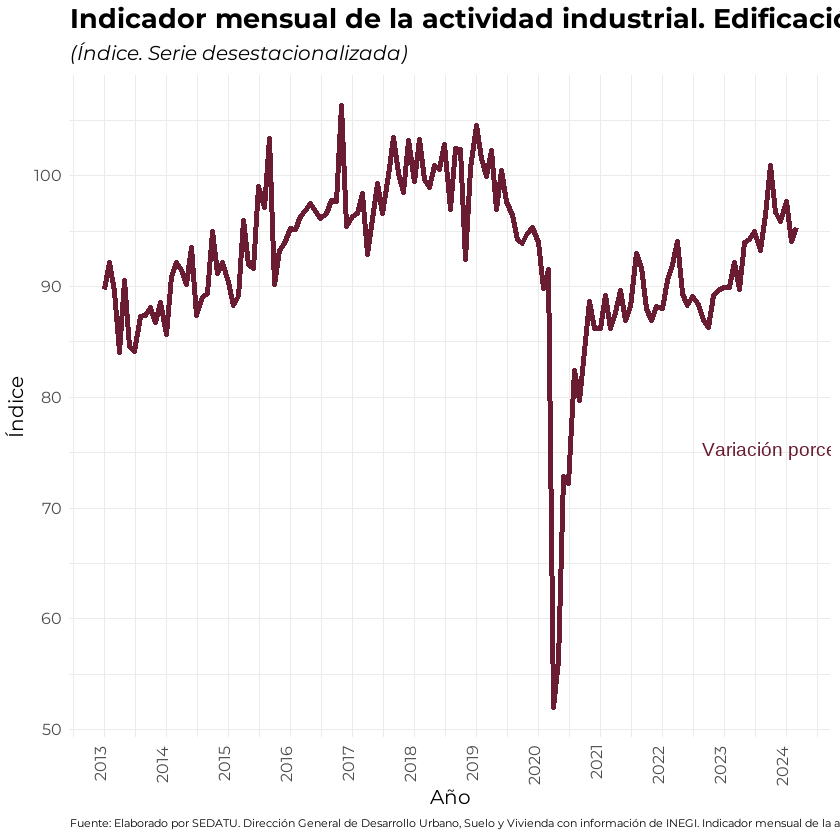

In [110]:
dfact%>%
graflinea(valor_x=fecha,valor_y=obs_value,"Año","Índice","Indicador mensual de la actividad industrial. Edificación","(Índice. Serie desestacionalizada)","Fuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información de INEGI. Indicador mensual de la actividad industrial.", paleta[1])
ggsave("actividad_economica.png",width=10,height=6,bg="white",dpi=200)

In [111]:
# Empleos
urlemp<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/720397/es/0700/false/BIE/2.0/a004f0de-f1d3-0adf-1bfb-81bac98fa7b5?type=json"
empleos<-consulta_api(urlemp)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
mutate(obs_value=as.numeric(obs_value))%>%
#Extrar mes y año de la variable time_period
separate(time_period, into = c("año", "mes"), sep = "/")%>%
select(año,mes,obs_value)%>%
mutate(año=as.integer(año),
         mes=as.integer(mes))%>%
filter(año>=2013)%>%
arrange(año,mes)%>%
#Calcular variaciones anuales
mutate(varpct=(obs_value/lag(obs_value,12)-1)*100)%>%
#Crear variable fecha
mutate(fecha=as.Date(paste0(año,"-",mes,"-01"))
)
empleos

año,mes,obs_value,varpct,fecha
<int>,<int>,<dbl>,<dbl>,<date>
2013,1,109.5737,NA,2013-01-01
2013,2,110.8979,NA,2013-02-01
2013,3,110.7819,NA,2013-03-01
2013,4,111.4653,NA,2013-04-01
2013,5,112.3649,NA,2013-05-01
2013,6,110.7182,NA,2013-06-01
2013,7,109.1680,NA,2013-07-01
2013,8,108.2443,NA,2013-08-01
2013,9,107.2917,NA,2013-09-01


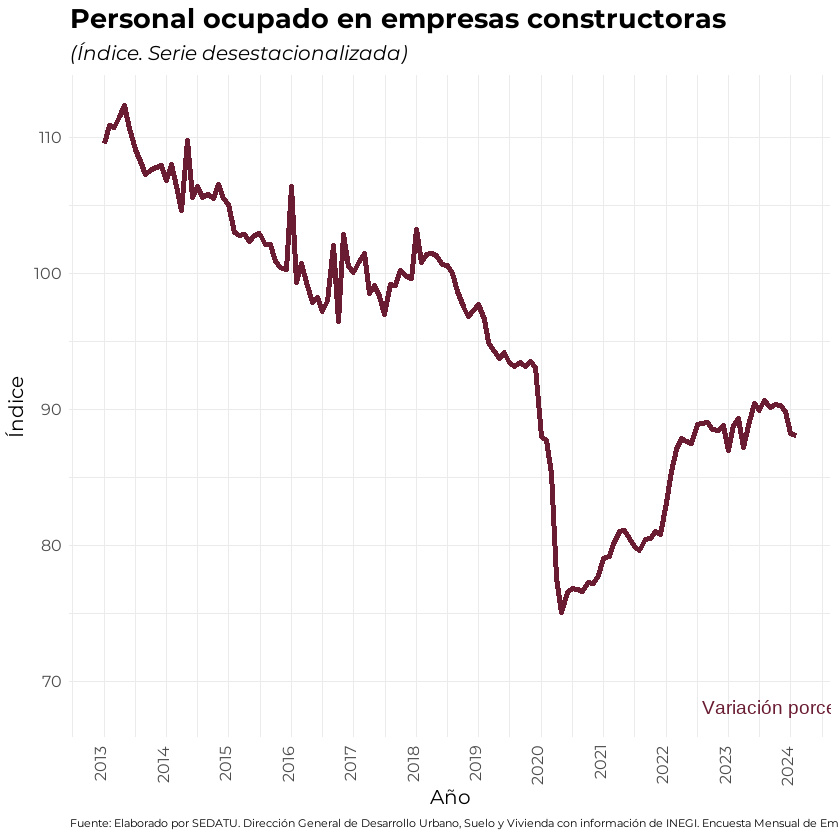

In [112]:
empleos%>%
graflinea(valor_x=fecha,valor_y=obs_value,"Año","Índice","Personal ocupado en empresas constructoras","(Índice. Serie desestacionalizada)","Fuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información de INEGI. Encuesta Mensual de Empresas Constructoras.", paleta[1])
ggsave("empleos_const.png",width=10,height=6,bg="white",dpi=200)

### Financiamientos

In [113]:
urlfin<-"https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2022,2023/0/0/organismo,modalidad,anio,destino_credito,rango_salarial"

In [114]:
financiamientos<-consulta_api(urlfin)

financiamientos

,año,organismo,modalidad,destino_credito,rango_salarial,acciones,monto
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,2022,FOVISSSTE,Viviendas nuevas,Vivienda nueva,2.6 o menos,1784,817784106
2,2022,FOVISSSTE,Viviendas nuevas,Vivienda nueva,2.61 a 4.00,8934,5312088868
3,2022,FOVISSSTE,Viviendas nuevas,Vivienda nueva,4.01 a 6.00,4948,3715539339
4,2022,FOVISSSTE,Viviendas nuevas,Vivienda nueva,6.01 a 9.00,4538,4760037463
5,2022,FOVISSSTE,Viviendas nuevas,Vivienda nueva,9.01 a 12.00,1910,1825718516
6,2022,FOVISSSTE,Viviendas nuevas,Vivienda nueva,Más de 12,621,166749668
7,2022,FOVISSSTE,Viviendas nuevas,Con disponibilidad de terreno,2.6 o menos,29,13966605
8,2022,FOVISSSTE,Viviendas nuevas,Con disponibilidad de terreno,2.61 a 4.00,146,90688489
9,2022,FOVISSSTE,Viviendas nuevas,Con disponibilidad de terreno,4.01 a 6.00,124,97584694


In [115]:
tablaresumen<-financiamientos%>%
filter(!organismo=="INVI")%>%
group_by(año, organismo)%>%
summarise(financiamientos=sum(acciones),monto=sum(monto))%>%
ungroup()%>%
actualiza_precios(inpc)%>%
#Crear ticket promedio
mutate(ticket_promedio=monto/financiamientos)%>%
mutate(ticket_promedio_act=monto_actualizado/financiamientos)

tablaresumen

`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


año,organismo,financiamientos,monto,mes,obs_value,inpc23,monto_actualizado,ticket_promedio,ticket_promedio_act
<int>,<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022,BANCA (CNBV),210454,290089235637,12,126.478,95.54667,277170618970,1378397.35,1317012.83
2022,BANJERCITO,667,865092177,12,126.478,95.54667,826566810,1296989.77,1239230.60
2022,CONAVI,70730,6037048897,12,126.478,95.54667,5768199484,85353.44,81552.38
2022,FOVISSSTE,48728,36429520208,12,126.478,95.54667,34807195250,747609.59,714316.11
2022,HABITAT MEXICO,1217,80954869,12,126.478,95.54667,77349686,66520.02,63557.67
2022,INFONAVIT,359849,159345567050,12,126.478,95.54667,152249390959,442812.31,423092.44
2022,INSUS,5092,68729185,12,126.478,95.54667,65668451,13497.48,12896.40
2022,SHF (FONDEO),54592,1089506047,12,126.478,95.54667,1040986801,19957.25,19068.49
2023,BANCA (CNBV),170606,276849450147,12,132.373,100.00000,276849450147,1622741.58,1622741.58


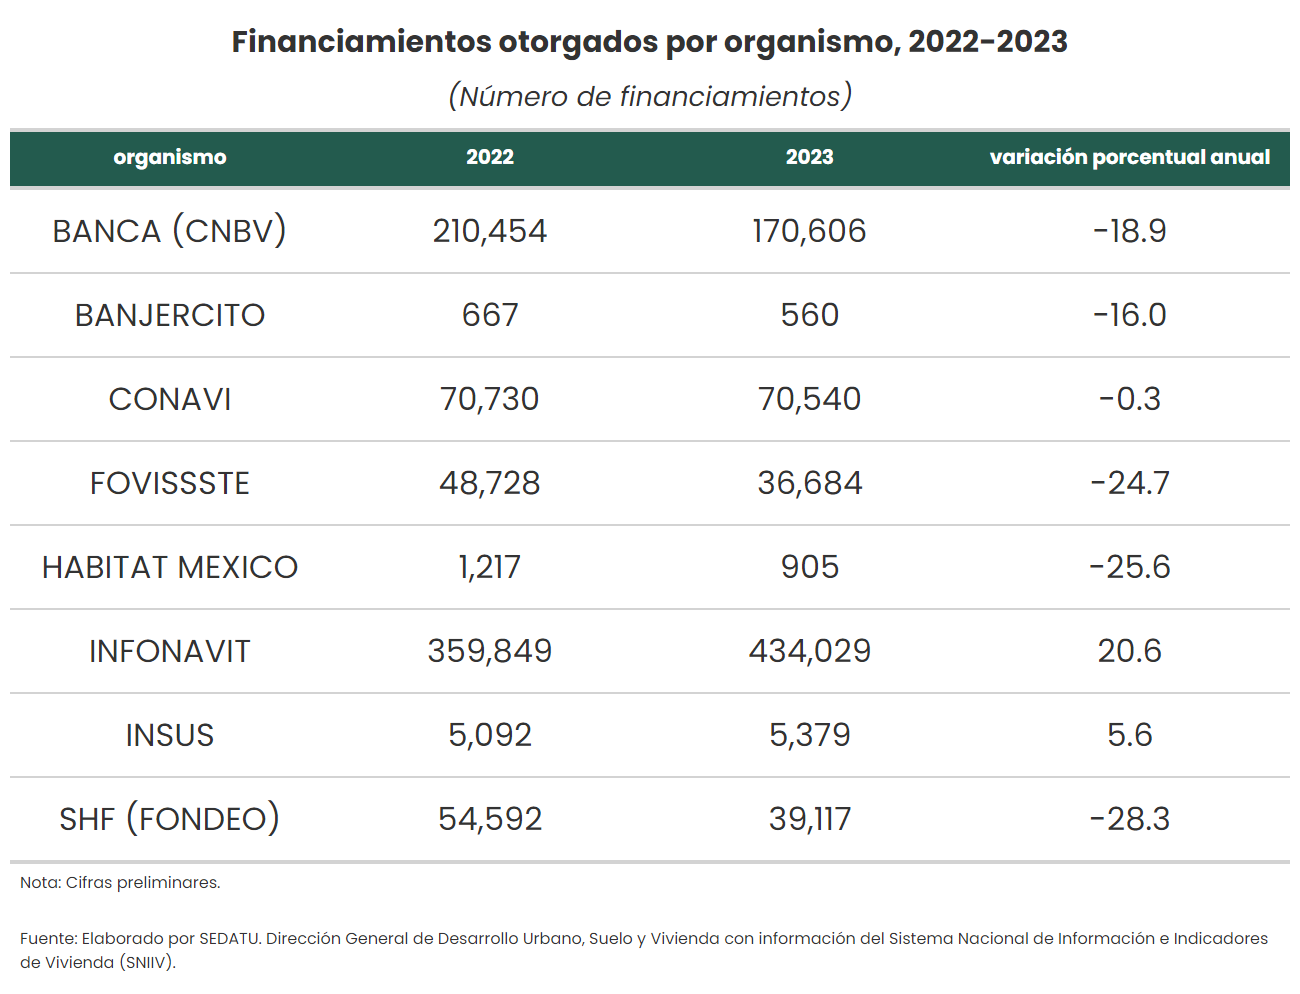

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1300    994 sRGB       TRUE    117547 72x72  

In [116]:
#Financiamientos
tablaresumen%>%
select(año,organismo,financiamientos)%>%
pivot_wider(names_from = año, values_from = financiamientos)%>%
#Variaciones
mutate(varpct=round((`2023`/`2022`-1)*100,1))%>%
#Renombrar organismo y varpct
rename("variación porcentual anual"=varpct)%>%

crea_tabla(titulo="Financiamientos otorgados por organismo, 2022-2023",subtitulo="(Número de financiamientos)",nota="",nombre_archivo="fin_acciones.png")

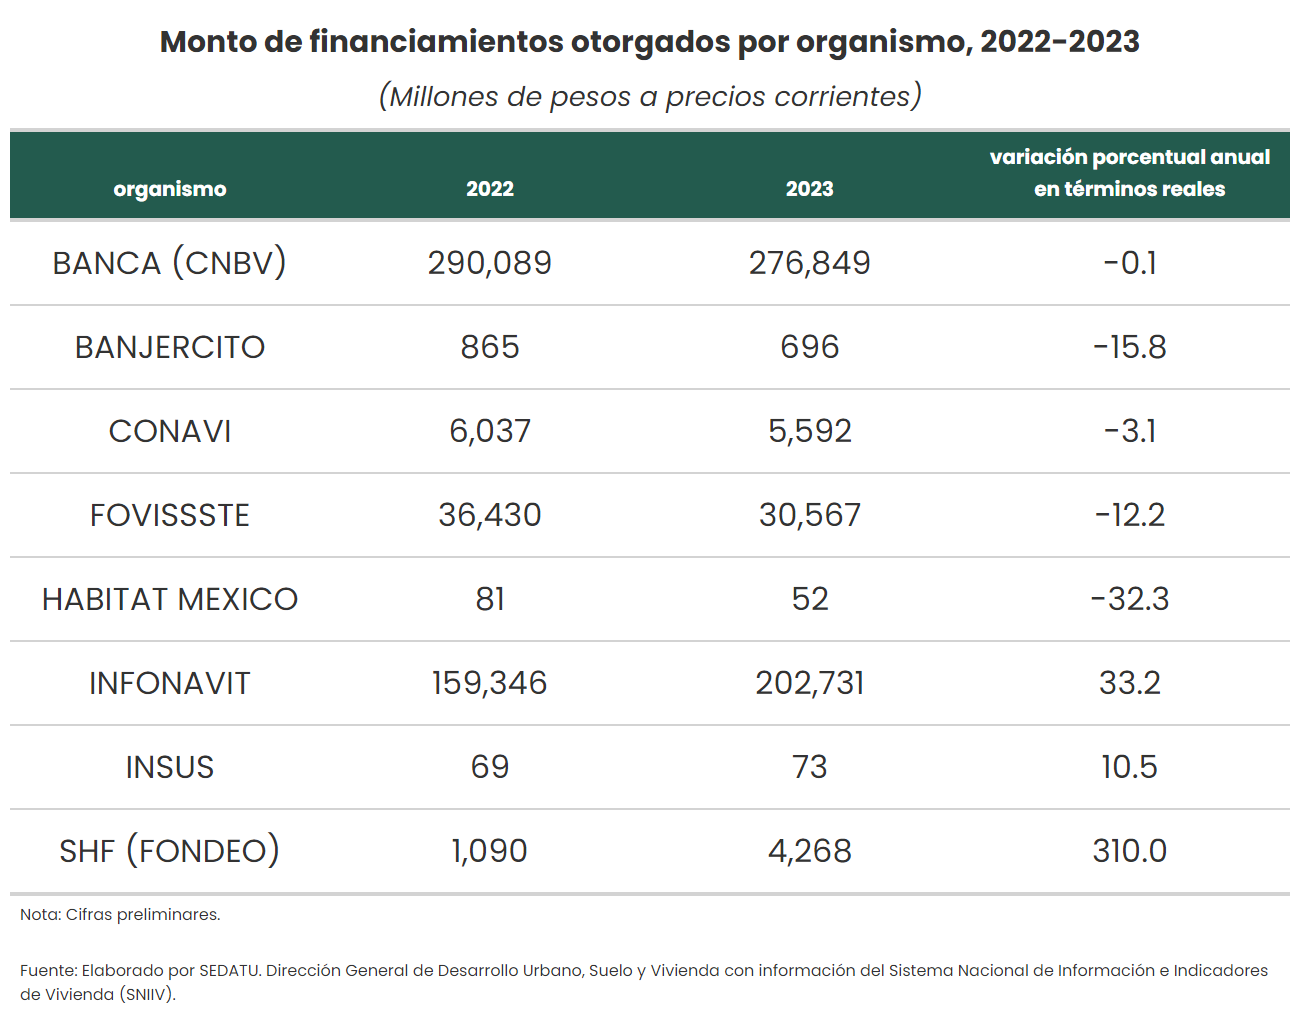

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1300   1026 sRGB       TRUE    122128 72x72  

In [117]:
#Financiamientos
tablaresumen%>%
select(año,organismo,monto,monto_actualizado)%>%
pivot_wider(names_from = año, values_from = c(monto,monto_actualizado))%>%
#Transformar a millones
mutate(across(where(is.numeric), ~./1e6))%>%
mutate(varpct=round((monto_actualizado_2023/monto_actualizado_2022-1)*100,1))%>%
select(organismo,monto_2022,monto_2023,varpct)%>%

rename("variación porcentual anual en términos reales"=varpct,"2022"="monto_2022","2023"="monto_2023")%>%

crea_tabla(titulo="Monto de financiamientos otorgados por organismo, 2022-2023",subtitulo="(Millones de pesos a precios corrientes)",nota="",nombre_archivo="fin_monto.png")

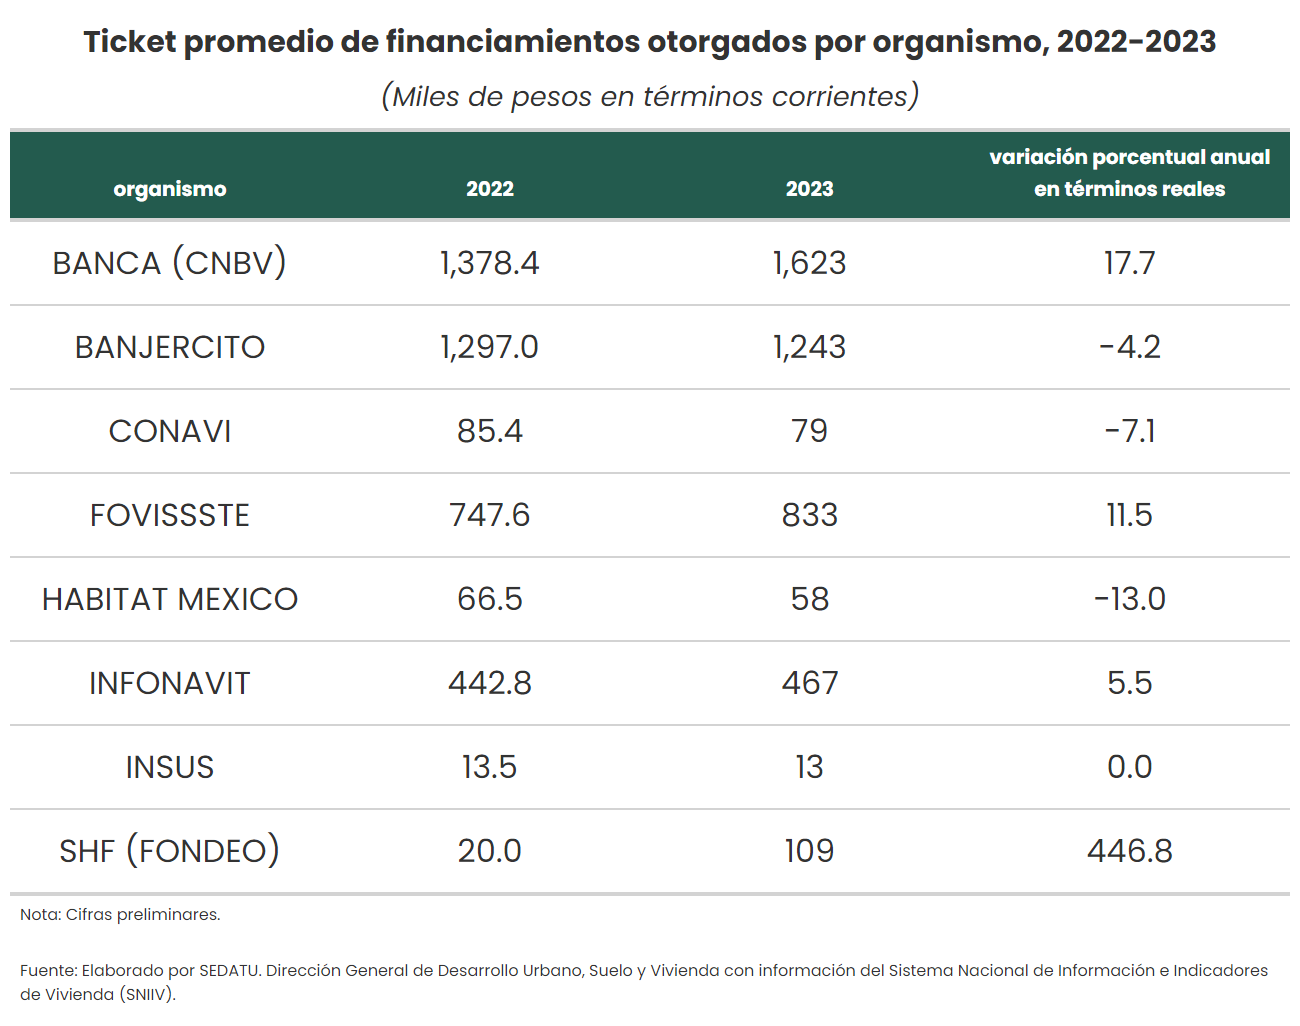

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1300   1026 sRGB       TRUE    116000 72x72  

In [118]:
#Financiamientos
tablaresumen%>%
select(año,financiamientos,organismo,monto,monto_actualizado)%>%
pivot_wider(names_from = año, values_from = c(financiamientos,monto,monto_actualizado))%>%
#crear ticket promedio
mutate(ticket_promedio_2022=monto_2022/financiamientos_2022,
ticket_promedio_2023=monto_2023/financiamientos_2023)%>%
#Datos a millones
mutate(across(where(is.numeric), ~./1e3))%>%
#Crear variaciones anuales
mutate(varpct=round(((monto_2023/financiamientos_2023)/(monto_2022/financiamientos_2022)-1)*100,1))%>%
select(organismo,ticket_promedio_2022,ticket_promedio_2023,varpct)%>%
rename("variación porcentual anual en términos reales"=varpct,"2022"="ticket_promedio_2022","2023"="ticket_promedio_2023")%>%
crea_tabla(titulo="Ticket promedio de financiamientos otorgados por organismo, 2022-2023",subtitulo="(Miles de pesos en términos corrientes)",nota="",nombre_archivo="fin_ticket.png")


`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


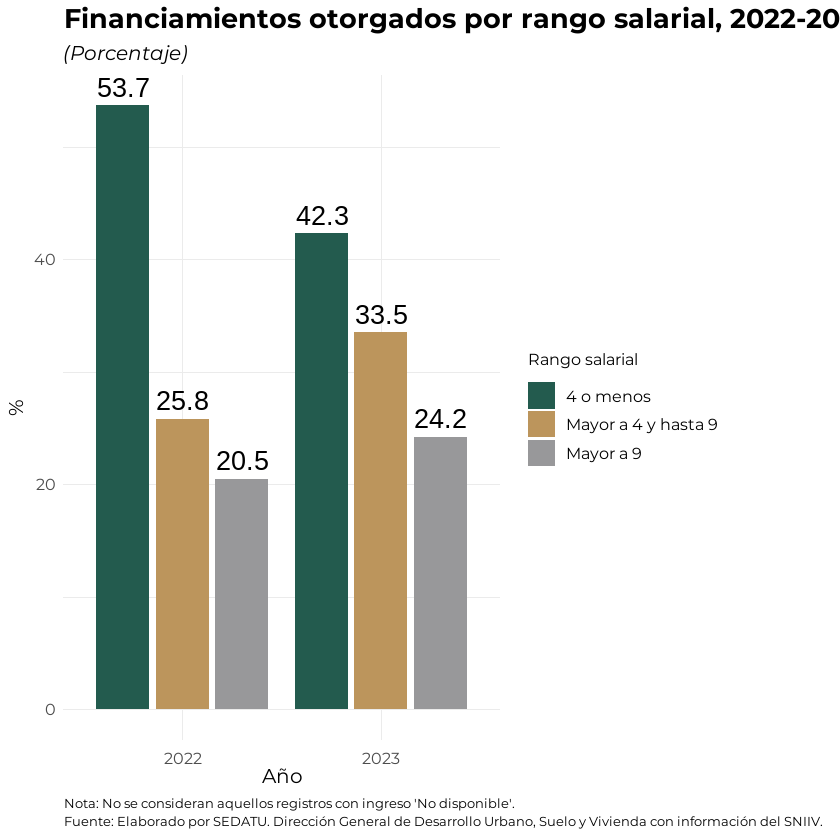

In [119]:
financiamientos%>%
filter(rango_salarial!="No disponible")%>%
mutate(rango_salarial=case_when(
    (rango_salarial=="2.6 o menos" | rango_salarial=="2.61 a 4.00")~"4 o menos",
(rango_salarial=="4.01 a 6.00" | rango_salarial=="6.01 a 9.00")~"Mayor a 4 y hasta 9",
TRUE~"Mayor a 9",
    
))%>%
rename("creditos"=acciones)%>%
crea_grafbarra(año,rango_salarial,"Año","%","Financiamientos otorgados por rango salarial, 2022-2023","(Porcentaje)", 
               "Nota: No se consideran aquellos registros con ingreso 'No disponible'.\nFuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del SNIIV.",
               "Rango salarial")
ggplot2::ggsave("financiamientos_rango.png",width=10,height=6,bg="white",dpi=150)

In [120]:
financiamientos %>%
  group_by(modalidad) %>%
  summarise(unique_destinos = list(unique(destino_credito)))


modalidad,unique_destinos
<chr>,<list>
Mejoramientos,"Mejoramientos , Ampliación , Con disponibilidad de terreno, Reconstrucción , Vivienda nueva"
Otros programas,"Pago de pasivos , Adquisición de suelo , Regularización de asentamientos, Insumos para vivienda , Liquidez"
Viviendas existentes,"Vivienda existente, Autoproducción , En arrendamiento"
Viviendas nuevas,"Vivienda nueva , Con disponibilidad de terreno, Autoproducción"


`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


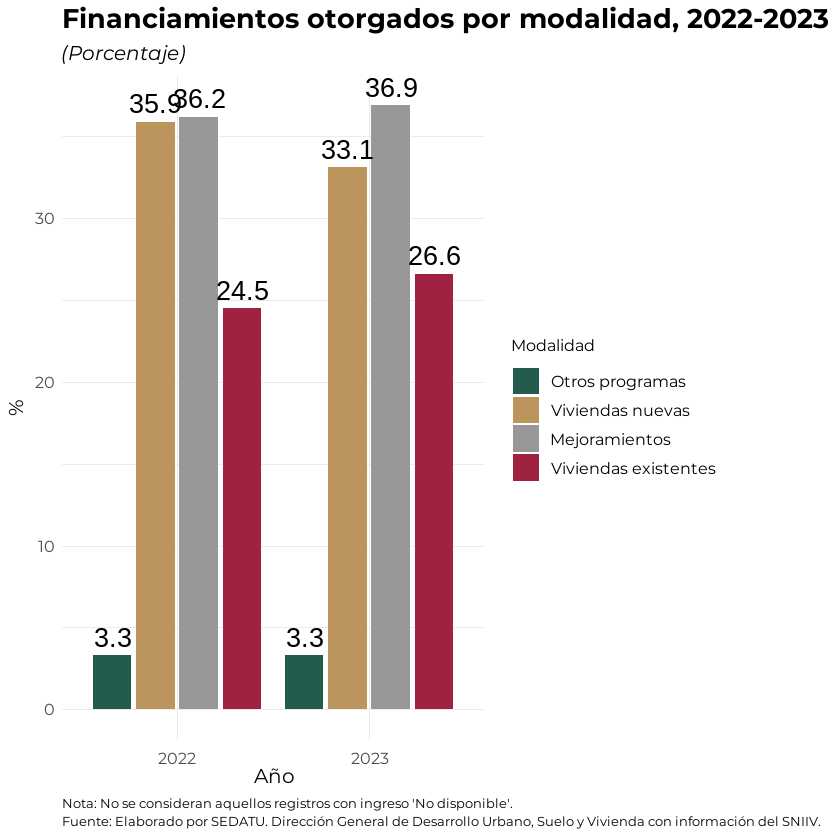

In [121]:
financiamientos%>%
rename("creditos"=acciones)%>%
#Ordenar de mayor a menor y hacer la variable factor
mutate(modalidad=fct_reorder(modalidad,creditos))%>%
crea_grafbarra(año,modalidad,"Año","%","Financiamientos otorgados por modalidad, 2022-2023","(Porcentaje)", 
               "Nota: No se consideran aquellos registros con ingreso 'No disponible'.\nFuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del SNIIV.",
               "Modalidad")

In [122]:
urlfinmes<-"https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2022,2023/0/0/organismo,anio,mes"


dist_fin<-consulta_api(urlfinmes)%>%
filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE" | organismo=="CONAVI" | organismo=="SHF (FONDEO)")%>%
mutate(organismo=case_when(
    organismo=="SHF (FONDEO)"~"SHF",
TRUE ~ organismo))


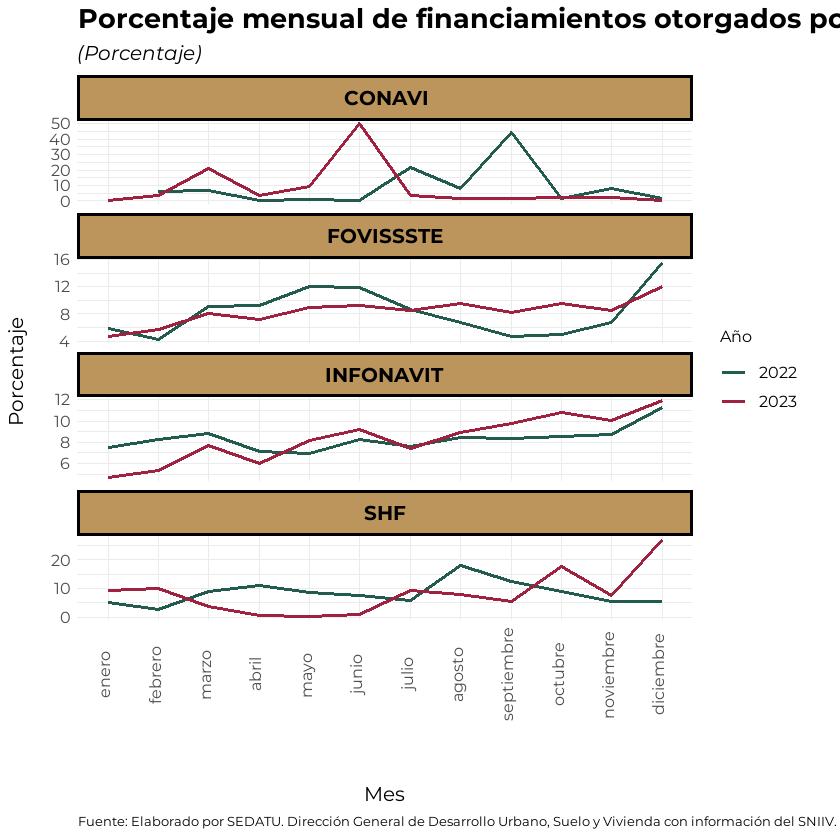

In [123]:

dist_fin %>%
  group_by(organismo, mes, año) %>%
  summarise(acciones = sum(acciones), .groups = 'drop') %>%
  ungroup() %>%
  # Create percentages within each year and organism group
  group_by(organismo, año) %>%
  mutate(porcentaje = acciones / sum(acciones) * 100) %>%
  ungroup() %>%
  # Correctly reorder 'mes' by converting it to a factor with predefined levels
  mutate(mes = factor(mes, levels = c("enero", "febrero", "marzo", "abril", "mayo", "junio", 
                                      "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"))) %>%
  # Plotting
  ggplot(aes(x = mes, y = porcentaje, color = as.factor(año), linetype = as.factor(año), group = interaction(organismo, año))) +
    geom_line(linewidth = 1) +
    scale_color_manual("Año", values = c("2022" = "#235b4e", "2023" = "#9f2241")) +
    scale_linetype_manual("Año", values = c("2022" = "solid", "2023" = "solid")) +
    facet_wrap(~ organismo, scales = "free_y", nrow = 4) +
    theme_minimal() +
    labs(x = "Mes", y = "Porcentaje",
         title = "Porcentaje mensual de financiamientos otorgados por organismo, 2022-2023",
         subtitle = "(Porcentaje)",
         caption = "Fuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del SNIIV.") +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 10),
      legend.position = "right",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 90, hjust = 0.5, vjust = 0.2),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop"),
      legend.text = element_text(size = 12),
      legend.title = element_text(size = 12),
            strip.background = element_rect(
          color="black", fill="#bc955c", 
          size=1.5, linetype="solid"
        ),
        strip.text = element_text(
          size = 15, color = "black", 
          face = "bold")
    )


ggsave("financiamientos_mensuales.png",width=10,height=6,bg="white",dpi=150)

In [124]:
# Financiamientos por estado

urlfinestado<-"https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2022,2023/0/0/organismo,anio,estado"

finedo<-consulta_api(urlfinestado)%>%
filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE" | organismo=="CONAVI" | organismo=="SHF (FONDEO)")%>%
mutate(organismo=case_when(
    organismo=="SHF (FONDEO)"~"SHF",
TRUE ~ organismo))%>%
#Eliminar No distribuido
filter(estado!="No distribuido")

In [125]:
mapagral<-finedo%>%
#Calcular variaciones anuales
group_by(año,estado)%>%
summarise(acciones=sum(acciones),monto=sum(monto))%>%
ungroup()
#%>%
# #Crea variación porcentual
# group_by(estado)%>%
# mutate(varpct=round((acciones/lag(acciones)-1)*100,1))
# 
# mapagral

`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


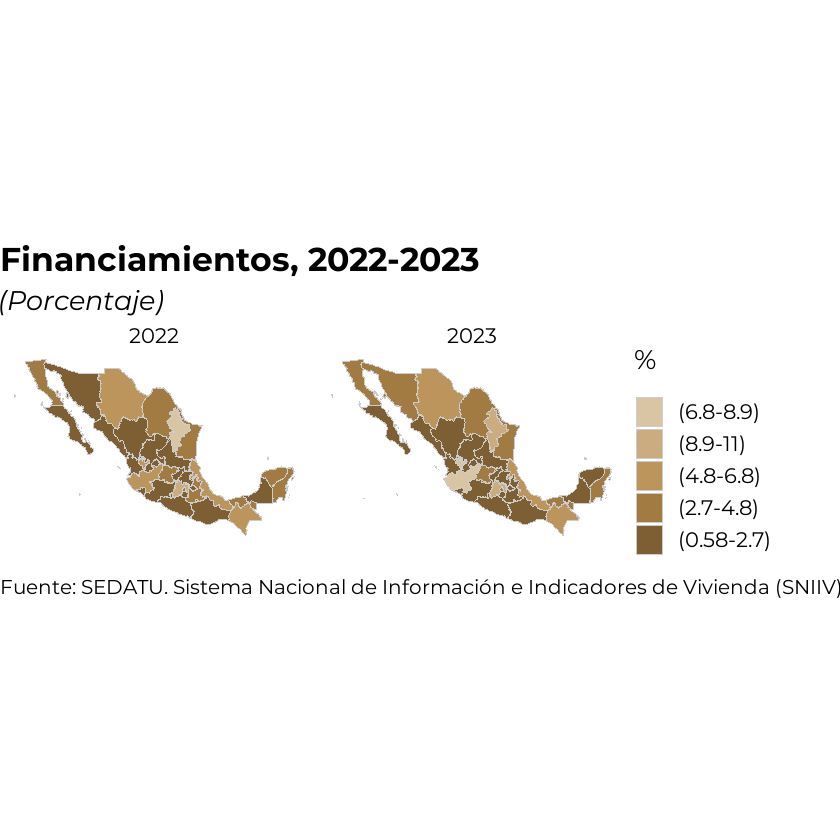

In [126]:
mapagral%>%
crea_mapa(paleta_mapa, "Financiamientos, 2022-2023",estados)


In [127]:
lista<-unique(finedo$organismo)
paleta_mapa<-rev(paleta_mapa)
for (org in lista) {
  # filtro
  df_organismo <- finedo %>%
    filter(org == organismo)

  # Llama a la función.
  mapa <- crea_mapa(df_organismo, paleta_mapa, org, estados)

  # Salva el mapa.
  ggsave(paste0("financiamientos_", org, ".png"), plot = mapa, width = 11, height = 8.5, dpi = 100, bg = "white")
}


`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


In [137]:
#Crecimiento por estado
crecfinedo<-finedo%>%
#Calcular variaciones anuales
group_by(año,estado, organismo)%>%
summarise(acciones=sum(acciones),monto=sum(monto))%>%
ungroup()%>%
#Crea variación porcentual
group_by(estado,organismo)%>%
mutate(varpct=round((acciones/lag(acciones)-1)*100,1))%>%
#Eliminar NA
filter(!is.na(varpct))
crecfinedo


`summarise()` has grouped output by 'año', 'estado'. You can override using the
`.groups` argument.


año,estado,organismo,acciones,monto,varpct
<int>,<chr>,<chr>,<int>,<dbl>,<dbl>
2023,Aguascalientes,FOVISSSTE,641,486667807,-34.3
2023,Aguascalientes,INFONAVIT,10000,4481808695,21.3
2023,Aguascalientes,SHF,394,72323713,-15.1
2023,Baja California,CONAVI,1918,85859227,236.5
2023,Baja California,FOVISSSTE,351,312258810,-30.8
2023,Baja California,INFONAVIT,22080,10294488904,14.6
2023,Baja California,SHF,217,21359007,34.0
2023,Baja California Sur,CONAVI,466,20119299,20.4
2023,Baja California Sur,FOVISSSTE,642,519066677,-19.2


In [164]:
for (org in lista) {
  # filtro
  df_organismo <- crecfinedo %>%
    filter(org == organismo)

  # Crea gráfica de barras ordenadas mostrando valores negativos correctamente
  p <- df_organismo %>%
    ggplot(aes(x = reorder(estado, varpct), y = varpct, fill = varpct)) +
    geom_col(fill="#235b4e", width = 0.7) +

      geom_text(
      aes(label = format(varpct, big.mark = ",", scientific = FALSE, trim = TRUE), vjust = ifelse(varpct > 0, -0.3, 1.5)), 
      size = 4) +  
    theme_minimal() +

labs(x = "Estado", y = "Variación porcentual anual",
            title = paste0(org, ". Variación porcentual anual en financiamientos otorgados por entidad federativa, 2022-2023"),
            subtitle = "(Porcentaje)",
            caption = "Fuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del SNIIV.") +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),  # Centered title
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 10),
      legend.position = "right",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 90, hjust = 0.5, vjust = 0.5),
      axis.text.y = element_text(size = 12),
      legend.text = element_text(size = 12),
      legend.title = element_text(size = 12),
          text=element_text("pop",
                            size=20))

  # Save the plot.
  ggsave(paste0("crecfinedo_", org, ".png"), plot = p, width = 11, height = 8.5, dpi = 150, bg = "white")
}


### Registro de vivienda

In [166]:
urlregistro<- "https://sniiv.sedatu.gob.mx/api/CuboAPI/GetRegistro/2022,2023/00/0/anio,estado,mes,pcu"

registro<-consulta_api(urlregistro)
registro

,año,mes,estado,pcu,viviendas
,<int>,<chr>,<chr>,<chr>,<int>
1,2023,enero,Coahuila de Zaragoza,U3,366
2,2023,mayo,Hidalgo,FC,215
3,2022,noviembre,Coahuila de Zaragoza,FC,108
4,2022,febrero,Jalisco,FC,565
5,2023,octubre,Zacatecas,U1,1
6,2023,julio,Oaxaca,U3,4
7,2023,mayo,Zacatecas,U2,20
8,2022,diciembre,Tamaulipas,U1,6
9,2023,septiembre,Puebla,U3,507


`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


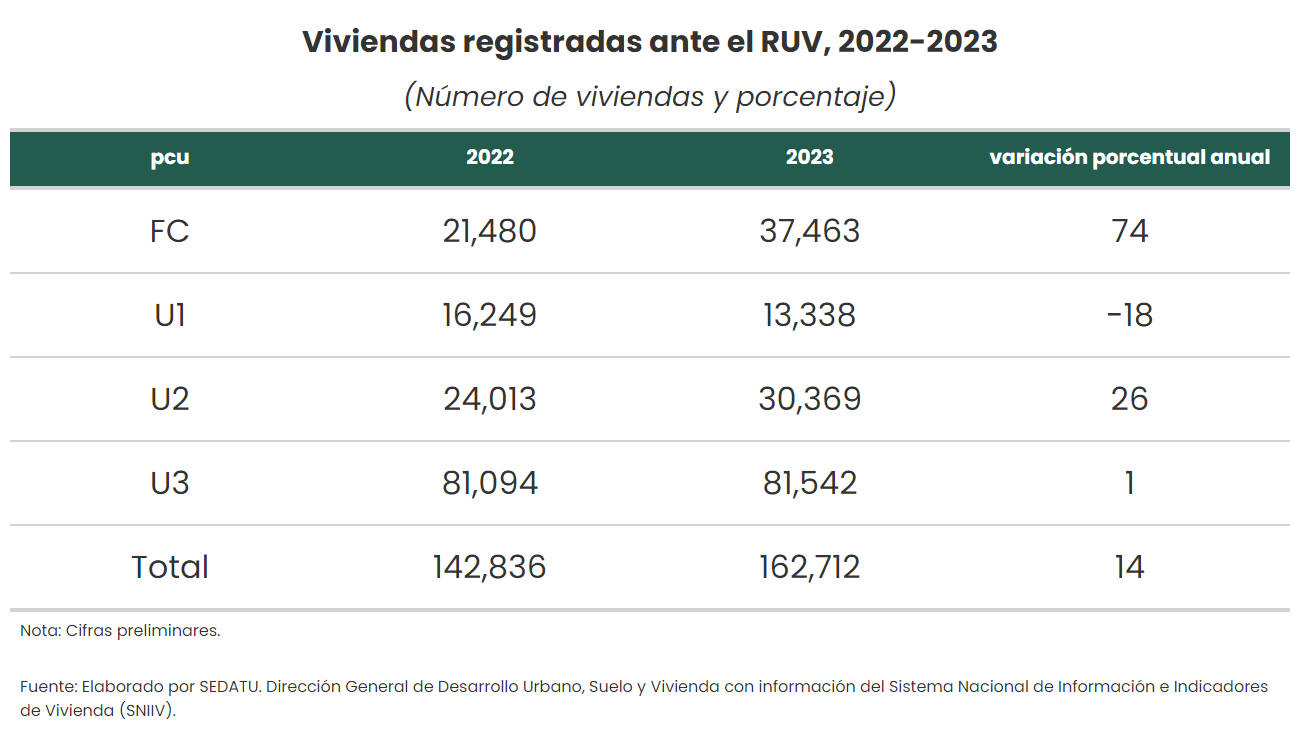

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1300    742 sRGB       TRUE     77358 72x72  

In [188]:
tablaregistro<-registro%>%
group_by(año, pcu)%>%
summarise(viviendas=sum(viviendas))%>%
pivot_wider(names_from = año, values_from = viviendas)%>%
janitor::adorn_totals(where = "row")%>%
mutate(varpct=round((`2023`/`2022`-1)*100,2))%>%
rename("variación porcentual anual"=varpct)%>%
crea_tabla(titulo="Viviendas registradas ante el RUV, 2022-2023",subtitulo="(Número de viviendas y porcentaje)",nota="",nombre_archivo="viviendasruv.png")
tablaregistro

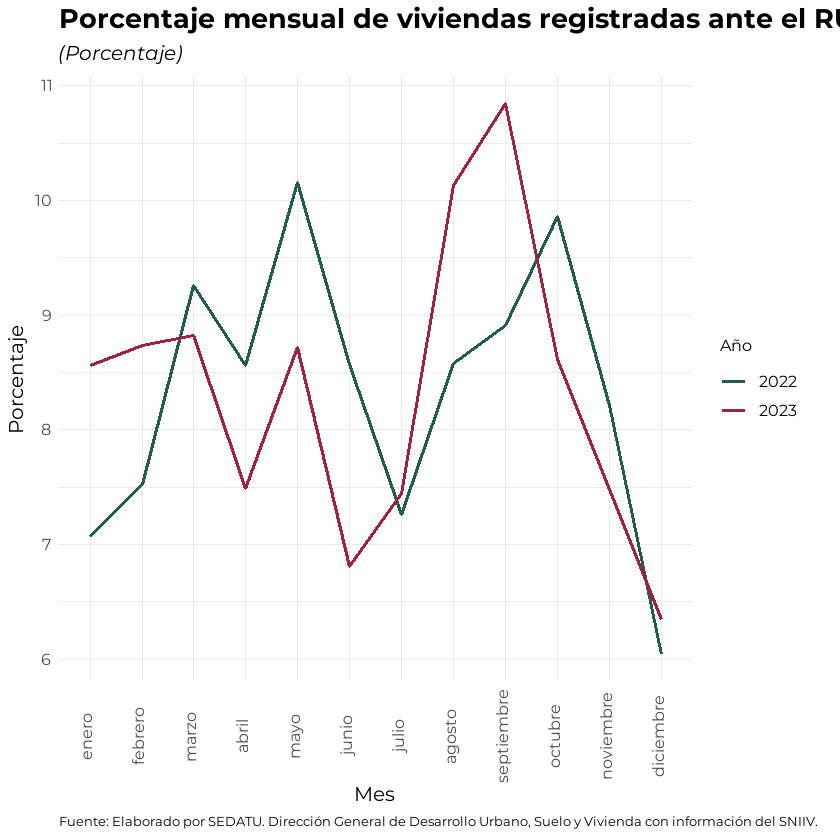

In [177]:
registro%>%
group_by(mes, año) %>%
  summarise(viviendas = sum(viviendas), .groups = 'drop') %>%
  ungroup() %>%
  # Create percentages within each year and organism group
  group_by(año) %>%
  mutate(porcentaje = viviendas / sum(viviendas) * 100) %>%
  ungroup() %>%
  # Correctly reorder 'mes' by converting it to a factor with predefined levels
  mutate(mes = factor(mes, levels = c("enero", "febrero", "marzo", "abril", "mayo", "junio", 
                                      "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"))) %>%
  # Plotting
  ggplot(aes(x = mes, y = porcentaje, color = as.factor(año), linetype = as.factor(año), group=as.factor(año))) +
    geom_line(linewidth = 1) +
    scale_color_manual("Año", values = c("2022" = "#235b4e", "2023" = "#9f2241")) +
    scale_linetype_manual("Año", values = c("2022" = "solid", "2023" = "solid")) +
    
    theme_minimal() +
    labs(x = "Mes", y = "Porcentaje",
         title = "Porcentaje mensual de viviendas registradas ante el RUV, 2022-2023",
         subtitle = "(Porcentaje)",
         caption = "Fuente: Elaborado por SEDATU. Dirección General de Desarrollo Urbano, Suelo y Vivienda con información del SNIIV.") +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 10),
      legend.position = "right",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 90, hjust = 0.5, vjust = 0.2),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop"),
      legend.text = element_text(size = 12),
      legend.title = element_text(size = 12)
    )

